In [57]:
import sys
import os
import math
import numpy as np
import pandas as pd
from sklearn.preprocessing import normalize
import scipy.sparse as sp
#from scipy.sparse import random
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
import scipy.optimize as sop
import seaborn
import random


# NOTE: I am ignoring the max iteration warnings for nmf
import warnings
warnings.filterwarnings("ignore")

cwd = os.getcwd()
#par = os.path.join(cwd, os.pardir)
par = os.path.dirname(cwd)
sys.path.append(par)

import sparse_nmf
import diffusion_nmf
import importlib
importlib.reload(sparse_nmf)
importlib.reload(diffusion_nmf)
from sparse_nmf import SparseNMF
from diffusion_nmf import DiffusionNMF

### Generate Data

In [5]:
def gen_data():
    # generates testing data
    test_h = sp.random(4,52, density = 0.07).A
    
    # make sure the rows aren't too correlated with each other and that there are no zero rows
    while np.linalg.norm(np.corrcoef(test_h) - np.identity(4)) > 0.3 or np.where(np.sum(test_h, axis = 1) == 0)[0].size != 0:
        test_h = sp.random(4,52, density = 0.07).A
    H = pd.DataFrame(test_h)

    x = np.linspace(1,10,300)
    y1 = stats.norm.pdf(x, 5) * 20
    y2 = []
    y3 = []
    y4 = []
    for i in x:
        y2.append((i - 5)**2)
        y3.append(2 * i)
        y4.append((i - 5)**3/10 + 10)
    y4 = np.array(y4)

    
    W = pd.DataFrame(np.array([y1, y2, y3, y4]).T)
    W /= W.max().max()

    return W,H

In [6]:
W,H = gen_data()

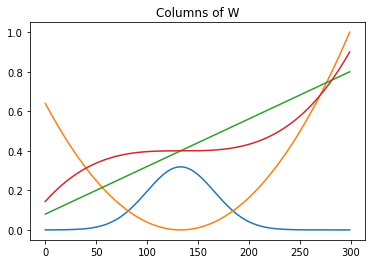

In [7]:
for col in W:
    plt.plot(W.loc[:,col])
    plt.title("Columns of W")

Text(0.5, 1.0, 'Sparse H')

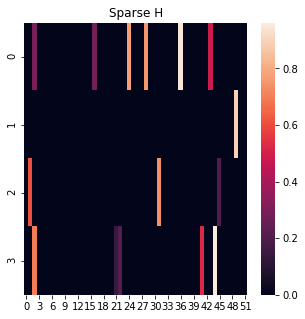

In [8]:
plt.figure(figsize = (5,5))
seaborn.heatmap(H, square = False, cbar = True)
plt.title("Sparse H")

In [52]:
# sparseness of H
def h_sparseness(h):
    h_sparse = 0
    for row in h.index:
        rh = np.array(h.loc[row,:])
        sp = math.sqrt(len(rh)) - (sum(np.abs(rh))/ math.sqrt(sum(rh ** 2)))
        sp /= (math.sqrt(len(rh)) - 1)
        h_sparse += sp
    
    h_sparse /= len(h.index)
    
    return h_sparse

In [53]:
h_sparseness(H)

0.8891779875440506

### Preliminaries

In [10]:
def plotter(data, out_W,out_H, K_in = None, title = " "):
    # plot columns of W
    fix, ax = plt.subplots(1, 2, figsize = (10,5))
    for col in out_W:
        ax[0].plot(out_W.loc[:,col])
        ax[1].plot(W.loc[:,col])

    ax[0].set_title("W output for " + str(title))
    ax[1].set_title("Original columns of W")
    
    # plot heatmap of H
    fig, ax = plt.subplots(1, 2, figsize = (10,5))
    seaborn.heatmap(out_H, square = False, cbar = True, ax = ax[0])
    ax[0].set_title("H output for " + str(title))
    seaborn.heatmap(H, square = False, cbar = True, ax = ax[1])
    ax[1].set_title("Original H")
    
    plt.show()
    
    if K_in is None:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on X: ", np.linalg.norm(data - np.dot(out_W, out_H)))
    else:
        print(title + "error on W: ", np.linalg.norm(W - out_W))
        print(title + "error on H: ", np.linalg.norm(H - out_H))
        print(title + "error on D: ", np.linalg.norm(data - np.dot(out_W, np.dot(out_H,K_in))))
    print()

In [29]:
def reorder(w,h,x,v):
    '''
    her = np.linalg.norm(np.corrcoef(h) - np.identity(4))
    ver = np.linalg.norm(np.corrcoef(v) - np.identity(4))
    print(her)
    print(ver)
    if ver > her + 0.2:
        pass
        #raise ValueError('Rows of V are too correlated')
    '''
        
    hv = np.corrcoef(h, v)[0:4,4:]
    horder, vorder = sop.linear_sum_assignment(hv, maximize = True)
    
    wx = np.corrcoef(w,x, rowvar = False)[4:,0:4]
    worder, xorder = sop.linear_sum_assignment(wx, maximize = True)

    #if not np.array_equal(vorder, xorder):
    #    raise ValueError("ordering is unclear")

    x = x[:,vorder]
    v = v[vorder]
    return x,v

In [18]:
def diffn_plot(w, h, lap, beta_vals, iters = 1000, algorithm = 'MultUpdate', sparseness = None, lambda_v = None, beta = None, eta = None):
    # plot the diffusion NMF results over a range of beta values
    # parameters include original w and h, the laplacian, desired level of sparseness, total iterations for NMf
    # and options for a projection version of the algorithm and an alternating least squares version
    I = np.identity(len(lap))
    for beta in beta_vals:
            Kinv = I + beta * lap
            K = np.linalg.inv(Kinv)
                
            D = np.dot(w, np.dot(h, K))
            print("K Condition Number : " + str(np.linalg.cond(K)))

            differ = DiffusionNMF(D, K, ncomponents = 4, iterations = iters, tol = 1e-20)
            differ.solver(algorithm, sparseness, lambda_v, beta, eta)
                
            diffX,diffV = reorder(w,h,differ.X, differ.V)
            diffX = pd.DataFrame(diffX)
            diffV = pd.DataFrame(diffV)

            plotter(D, diffX, diffV, K_in = K, title = "Diffusion NMF @ beta = " + str(beta) + " ")
            
    return diffX, diffV

In [19]:
I = np.identity(np.dot(W,H).shape[1])

In [20]:
state_L = pd.read_csv(os.path.join(par, "collected_data/state_laplacian.csv"), index_col = 0).to_numpy()

### Reordering Output

K Condition Number : 30.871282980836465
0.1691247459700679
2.009647422054998


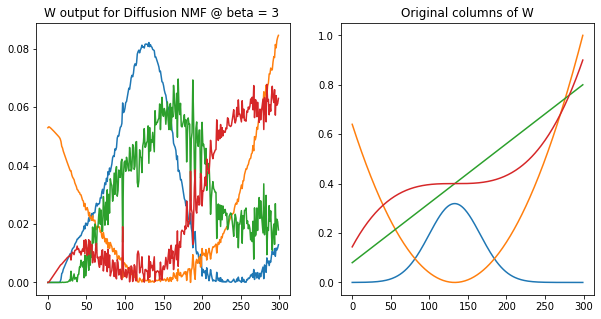

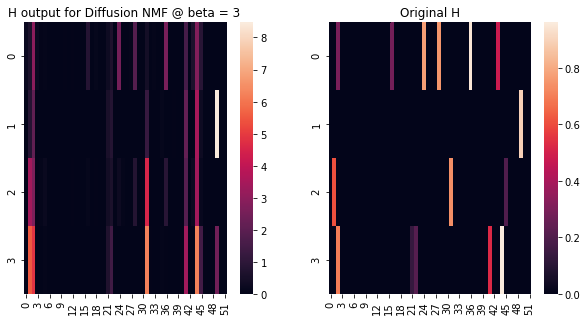

Diffusion NMF @ beta = 3 error on W:  12.72151593601069
Diffusion NMF @ beta = 3 error on H:  17.039722140321064
Diffusion NMF @ beta = 3 error on D:  0.1311631505756115



In [26]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultUpdate',sparseness = None)

K Condition Number : 10.95709432694549
0.1691247459700679
0.17680434732121802


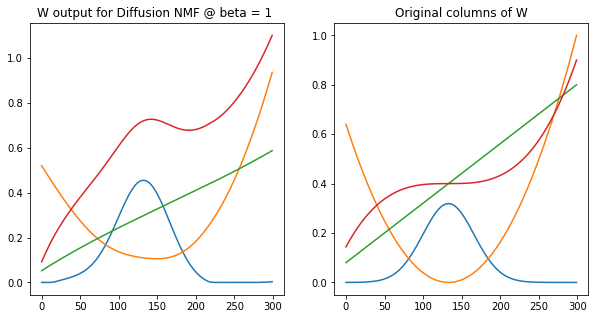

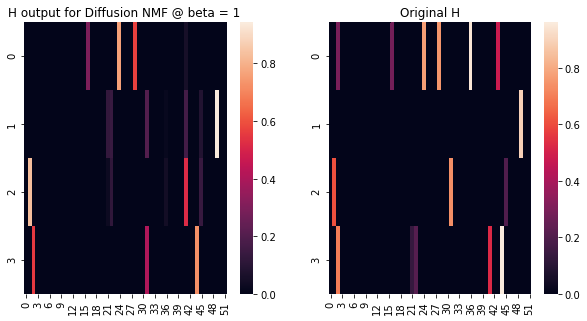

Diffusion NMF @ beta = 1 error on W:  4.684542088682489
Diffusion NMF @ beta = 1 error on H:  1.687352949142229
Diffusion NMF @ beta = 1 error on D:  0.6256764502868167



In [30]:
X,V = diffn_plot(W,H,state_L, [1], algorithm = 'HoyerP',sparseness = h_sparse)

K Condition Number : 30.871282980836465
0.1691247459700679
0.4445925211167151


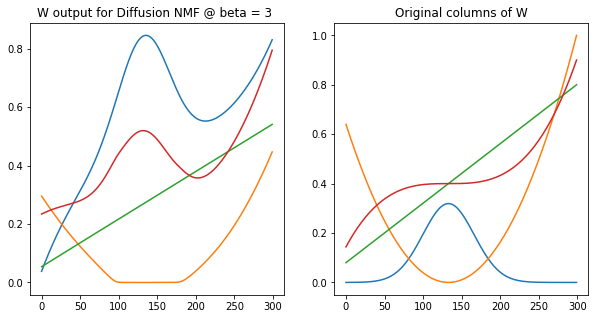

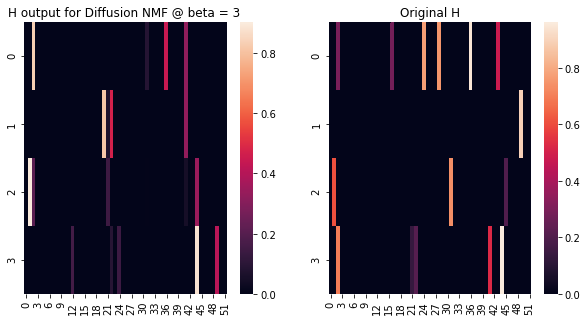

Diffusion NMF @ beta = 3 error on W:  10.03623013017698
Diffusion NMF @ beta = 3 error on H:  2.407092740209852
Diffusion NMF @ beta = 3 error on D:  0.5959766668082946



In [32]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'MultProj', sparseness = h_sparse)

K Condition Number : 10.95709432694549
0.1691247459700679
1.8012534602795995


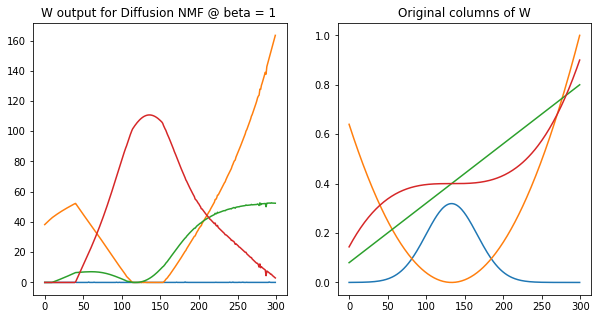

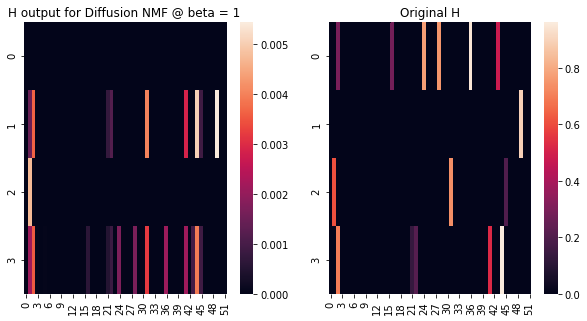

Diffusion NMF @ beta = 1 error on W:  1552.9240711532236
Diffusion NMF @ beta = 1 error on H:  2.4374691803835637
Diffusion NMF @ beta = 1 error on D:  0.5646412440181178



In [37]:
X,V = diffn_plot(W,H,state_L, [1], iters = 1000, algorithm = 'HoyerS', lambda_v = 1)

K Condition Number : 30.871282980836465
0.1691247459700679
0.14605320780714942


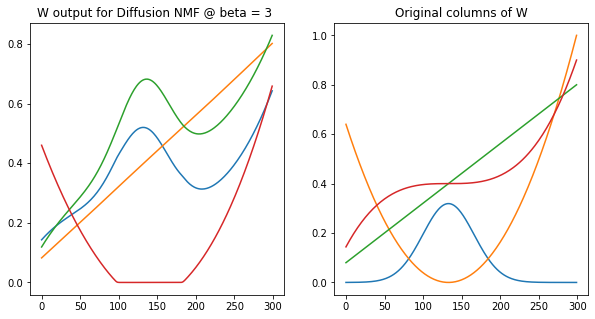

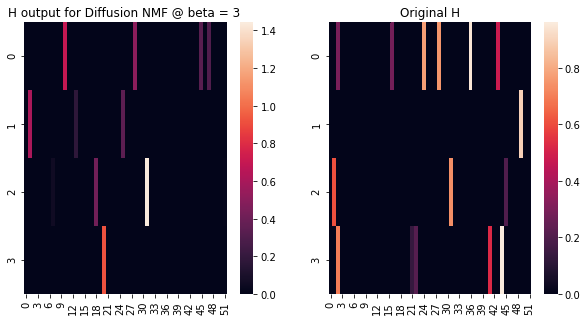

Diffusion NMF @ beta = 3 error on W:  9.662355999288973
Diffusion NMF @ beta = 3 error on H:  2.7662450316870753
Diffusion NMF @ beta = 3 error on D:  1.182882571380719



In [39]:
X,V = diffn_plot(W,H,state_L, [3], algorithm = 'TwoPhase', sparseness = h_sparse)

### Comparing algorithms

In [40]:
def correlation(x, y, axis = 1):
    # computes the correlation between matrices x and y
    summer = 0
    if axis == 0:
        for r in range(len(x.T)):
            corr = np.corrcoef(x.T[r], y.T[r])[0][1]
            if not np.isnan(corr):
                summer += corr
        cor_avg = summer / len(x.T)
        return cor_avg
    else:
        for r in range(len(x)):
            corr = np.corrcoef(x[r], y[r])[0][1]
            summer += corr
        cor_avg = summer / len(x)
        return cor_avg

In [44]:
def comparer(d,x,v,k):
    res1 = []
    res2 = []

    # Normal errors
    res1.append(np.linalg.norm(d - np.dot(x, np.dot(v, k))))
    res1.append(np.linalg.norm(W - x))
    res1.append(np.linalg.norm(H - v))

    # correlation
    d_test = np.dot(x, np.dot(v, k))
    res2.append(correlation(d, d_test, axis = 0))
    res2.append(correlation(W.to_numpy(), x, axis = 0))
    res2.append(correlation(H.to_numpy(), v, axis = 1))
    return res1, res2

In [68]:
def test_algs(d, w, h, K_b, sparseness,lambda_v = None, iters = 1000, noise = None):
    # for comparing the different algorithms
    #K_b = np.linalg.inv(I + beta * l)
    if lambda_v is None:
        lambda_v = sparseness * 10

    # algorithm 1 -- multiplicative update (no sparse constraint)
    if noise is not None:
        alg1 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg1 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg1.solver('MultUpdate')
    rx, rv = reorder(w,h,alg1.X, alg1.V)
    alg1_errs, alg1_corrs = comparer(d, rx, rv, K_b)
    

    # algorithm 2 -- modified Hoyer algorithm
    if noise is not None:
        alg2 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg2 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg2.solver('HoyerP', sparseness = sparseness)
    rx, rv = reorder(w,h,alg2.X, alg2.V)
    alg2_errs, alg2_corrs = comparer(d, rx, rv, K_b)
    

    # algorithm 3 -- projected Multiplicative update
    if noise is not None:
        alg3 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg3 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg3.solver('MultProj', sparseness = sparseness)
    rx, rv = reorder(w,h,alg3.X, alg3.V)
    alg3_errs, alg3_corrs = comparer(d, rx, rv, K_b)
    
    
    # algorithm 4 -- Hoyer sparse coding
    if noise is not None:
        alg4 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg4 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg4.solver('HoyerS', lambda_v = lambda_v)
    rx, rv = reorder(w,h,alg4.X, alg4.V)
    alg4_errs, alg4_corrs = comparer(d, rx, rv, K_b)
    

    # algorithm 5 -- two phase algorithm
    if noise is not None:
        alg5 = DiffusionNMF(noise, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    else:
        alg5 = DiffusionNMF(d, K_b, ncomponents = 4, iterations = iters, tol = 1e-20)
    alg5.solver('TwoPhase', sparseness = sparseness)
    rx, rv = reorder(w,h,alg5.X, alg5.V)
    alg5_errs, alg5_corrs = comparer(d, rx, rv, K_b)

    return np.array([alg1_errs, alg2_errs, alg3_errs, alg4_errs, alg5_errs]), np.array([alg1_corrs, alg2_corrs, alg3_corrs, alg4_corrs, alg5_corrs])

In [60]:
def noiser(matr, changes, std_dev = 1):
    # add noise to a matrix using gaussian random samples
    matr = np.matrix.copy(matr)
    noises = int(changes * matr.shape[0] * matr.shape[1])
    
    taken = {take:[] for take in range(matr.shape[0])}
    for n in range(noises):
        x = random.randint(0, matr.shape[0] - 1)
        while True:
            y = random.randint(0, matr.shape[1] - 1)
            if y not in taken[x]:
                break
        
        noisy = np.random.normal(scale = std_dev)
        if matr[x, y] + noisy < 0:
            matr[x, y] = 0
        else:
            matr[x, y] += noisy
            
    return matr

In [70]:
def test_with_noise(tests, K, iters = 1000):
    algs = [[] for i in range(5)]
    
    for t in range(len(tests)):
        w,h = gen_data()
        d = np.dot(w, np.dot(h, K))
        d_noise = noiser(d, 0.2, tests[t])
        spar = h_sparseness(h)
        
        for b in range(10):
            errz, corrz = test_algs(d,w,h,K, sparseness = spar,lambda_v = None, iters = iters, noise = d_noise)
            
            for e in range(len(errz)):
                algs[e] = np.concatenate((errz[e], corrz[e]))
                
    mult = pd.DataFrame(algs[0])
    hoyerp = pd.DataFrame(algs[1])
    multp = pd.DataFrame(algs[2])
    hoyers = pd.DataFrame(algs[3])
    twop = pd.DataFrame(algs[4])
        
                
    return mult, hoyerp, multp, hoyers, twop

In [55]:
K_real = np.linalg.inv(I + 3 * state_L)

In [72]:
mult, hoyerp, multp, hoyers, twop = test_with_noise([1,2,3,4,5], K_real)

0.2079086265200989
0.1415234608033163
0.2079086265200989
0.20240999934036055
0.2079086265200989
0.15072471436262339
0.2079086265200989
1.5208726489502353
0.2079086265200989
0.11424991350027354
0.2079086265200989
0.15479864074725236
0.2079086265200989
0.20105235012640926
0.2079086265200989
0.17359253904894353
0.2079086265200989
0.45278696221809234
0.2079086265200989
0.0938772444721918
0.2079086265200989
0.1416516980252293
0.2079086265200989
0.193102230884816
0.2079086265200989
0.18515111713825472
0.2079086265200989
1.836809829951259
0.2079086265200989
0.09591609490857132
0.2079086265200989
0.15554429230235037
0.2079086265200989
0.19035197825611755
0.2079086265200989
0.17012122881001515
0.2079086265200989
1.6844143784984857
0.2079086265200989
0.13663793593121454
0.2079086265200989
0.15408394078110998
0.2079086265200989
0.19937349837217164
0.2079086265200989
0.20599377677113132
0.2079086265200989
1.1462757747984564
0.2079086265200989
0.11502895785821034
0.2079086265200989
0.15346989425376